In [1]:
!pip install gymnasium
!pip install atari-py
!pip install gymnasium[atari]
!pip install gymnasium[accept-rom-license]

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.6/540.6 kB 3.3 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [402 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.linux-x86_64-3.10
      creating build/lib.linux-x86_64-3.10/atari_py
      copying atari_py/games.py -> build/lib.linux-x86_64-3.10/atari_py
      copying atari_py/__init__.py -> build/lib.linux-x86_64-3.10/atari_py
      copying atari_py/import_roms.py -> build/lib.linux-x86_64-3.10/atari_py
      copying atari_py/ale_python_interface.py -> build/lib.linux-x86_64-3.10/atari_py
      creating build/lib.linux-x86_64-3.10/atari_py/ale_interface
      

In [ ]:
import gym
import gymnasium as gym
from gymnasium import spaces
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
env = gym.make('PongNoFrameskip-v4')
# Сброс среды и получение первого наблюдения
obs = env.reset()

(210, 160, 3)


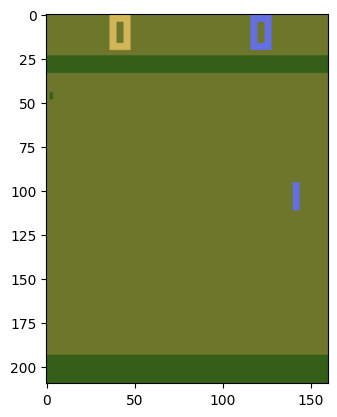

In [ ]:
plt.imshow(obs[0])
print(obs[0].shape)

In [ ]:
env.action_space

Discrete(6)

In [ ]:
env.observation_space

Box(0, 255, (210, 160, 3), uint8)

## Wrappers

### Observation Wrappers

1) Уменьшим размер, сделаем 128 на 128

2) Изменим цвет на grayscale

4) Добавим FramStack


In [ ]:
from gymnasium import ObservationWrapper
from cv2 import resize

class ResizeObservation(ObservationWrapper):
    def __init__(self, env, shape):
        super(ResizeObservation, self).__init__(env)
        self.shape = shape
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=shape[::-1], dtype=np.uint8)

    def observation(self, observation):
        observation = resize(observation, self.shape[1:], interpolation=cv2.INTER_AREA)
        return observation


(128, 128, 3)


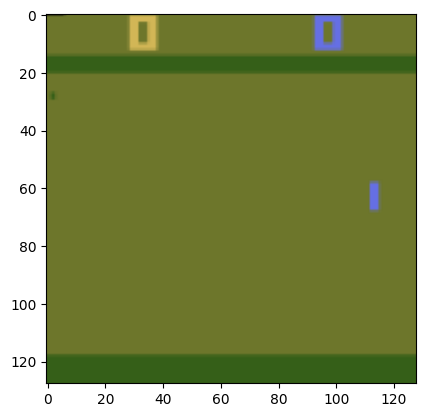

In [ ]:
env = gym.make('PongNoFrameskip-v4')
env = ResizeObservation(env, (3, 128, 128))
obs = env.reset()
plt.imshow(obs[0])
print(obs[0].shape)

In [ ]:
class GrayscaleObservation(ObservationWrapper):
    def __init__(self, env):
        super(GrayscaleObservation, self).__init__(env)
        obs_shape = self.observation_space.shape[:2] + (1,)  # Добавляем размерность канала
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        observation = np.mean(observation, axis=2)
        observation = np.expand_dims(observation, axis=2)
        return observation.astype(np.uint8)



(210, 160, 1)


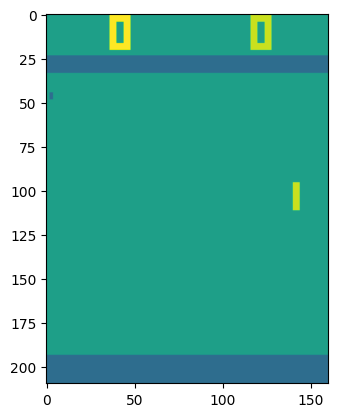

In [ ]:
env = gym.make('PongNoFrameskip-v4')
env = GrayscaleObservation(env)
obs = env.reset()
plt.imshow(obs[0])
print()
print(obs[0].shape)

In [ ]:
from gymnasium import Wrapper

class FrameStack(Wrapper):
    def __init__(self, env, num_stack):
        super(FrameStack, self).__init__(env)
        self.env = env
        self.num_stack = num_stack
        # Получаем исходные размеры наблюдения
        original_shape = env.observation_space.shape
        # Рассчитываем новую форму наблюдения с учётом стекирования кадров
        new_shape = (num_stack,) + original_shape
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=new_shape, dtype=np.uint8)
        # Инициализируем буфер для хранения стека кадров
        self.frames = np.zeros(new_shape, dtype=np.uint8)

    def reset(self):
        obs, t = self.env.reset()
        # Повторяем начальное наблюдение для заполнения всего стека
        for i in range(self.num_stack):
            self.frames[i] = obs
        return self._get_observation(), t

    def step(self, action):
        obs, reward, t, t_, info = self.env.step(action)
        # Сдвигаем стек кадров и добавляем новое наблюдение в начало
        self.frames = np.roll(self.frames, shift=1, axis=0)
        self.frames[0] = obs

        return self._get_observation(), reward, t, t_, info

    def _get_observation(self):

        return np.asarray(self.frames)

In [ ]:
env = gym.make('PongNoFrameskip-v4')
env = FrameStack(env, num_stack=4)
obs = env.reset()[0]

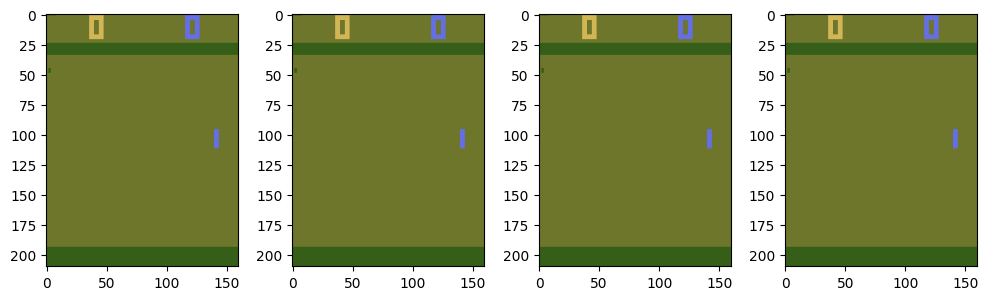

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,4,1)
plt.imshow(obs[0])
plt.subplot(1,4,2)
plt.imshow(obs[1])
plt.subplot(1,4,3)
plt.imshow(obs[2])
plt.subplot(1,4,4)
plt.imshow(obs[3])
plt.tight_layout()

In [ ]:
obs, _, _,_, _ = env.step(4)

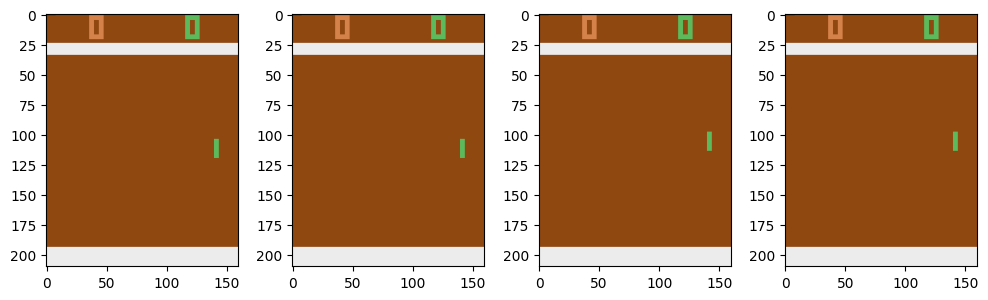

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,4,1)
plt.imshow(obs[0])
plt.subplot(1,4,2)
plt.imshow(obs[1])
plt.subplot(1,4,3)
plt.imshow(obs[2])
plt.subplot(1,4,4)
plt.imshow(obs[3])
plt.tight_layout()

### Action Wrappers

In [ ]:
import gymnasium as gym
from gymnasium import ActionWrapper
import numpy as np

class DiscretizeActionWrapper(ActionWrapper):
    def __init__(self, env, num_actions=3):
        super(DiscretizeActionWrapper, self).__init__(env)
        self.num_actions = num_actions
        # Устанавливаем новое пространство действий на дискретное с num_actions действиями
        self.action_space = gym.spaces.Discrete(num_actions)

    def action(self, action):
        # Преобразуем дискретное действие в непрерывное значение
        if action == 0:  # Двигаться влево
            return np.array([-1.0])
        elif action == 1:  # Ничего не делать
            return np.array([0.0])
        elif action == 2:  # Двигаться вправо
            return np.array([1.0])


In [ ]:

# Использование обёртки
env = gym.make('MountainCarContinuous-v0')
env = DiscretizeActionWrapper(env)
env.action_space


Discrete(3)

## Stable Baselines 3

#### Установка SB3 + wandb

In [ ]:
!pip install wandb
!pip install stable-baselines3[extra]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.7/181.7 kB 1.8 MB/s eta 0:00:00
  Attempting uninstall: shimmy
    Found existing installation: Shimmy 0.2.1
    Uninstalling Shimmy-0.2.1:
      Successfully uninstalled Shimmy-0.2.1
  Attempting uninstall: autorom
    Found existing installation: AutoROM 0.4.2
    Uninstalling AutoROM-0.4.2:
      Successfully uninstalled AutoROM-0.4.2


#### Обучение в SB3 с wandb

In [ ]:
import wandb
from stable_baselines3.common.monitor import Monitor


# Вход в систему (запустите это в Colab и следуйте инструкциям)
!wandb login
wandb.init(project="wandb_sb3", entity='babycar27')

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/usr/local/lib/python3.10/dist-packages/notebook/utils.py:280: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return LooseVersion(v) >= LooseVersion(check)
wandb: Currently logged in as: babycar27. Use `wandb login --relogin` to force relogin


In [ ]:
from stable_baselines3.common.callbacks import BaseCallback
import wandb

class WandbCustomCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(WandbCustomCallback, self).__init__(verbose)
        # Инициализация счетчика шагов
        # Инициализация wandb
        self.step = 0

    def _on_step(self) -> bool:
        # Логирование метрик на каждом шаге
        self.step += 1
        # Получаем последние значения среды (награды, информацию и т.д.)
        infos = self.locals["infos"]

        for info in infos:
            if "episode" in info.keys():
                # Логируем суммарную награду и длину эпизода
                wandb.log({"reward": info["episode"]["r"], "length": info["episode"]["l"]}, step=self.step)

        return True

In [ ]:
import wandb
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env


# Создание среды
env = make_vec_env('CartPole-v1', n_envs=4)

# Создание модели
model = PPO("MlpPolicy", env, verbose=1)

# Обучение модели с WandbCustomCallback
model.learn(total_timesteps=20000, callback=WandbCustomCallback())


Using cuda device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.3     |
|    ep_rew_mean     | 24.3     |
| time/              |          |
|    fps             | 1479     |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 36.6        |
|    ep_rew_mean          | 36.6        |
| time/                   |             |
|    fps                  | 990         |
|    iterations           | 2           |
|    time_elapsed         | 16          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.013796083 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.682      |
|    explained_variance   | 0.001       |
|    learnin

### Сравнение обучений с wrapper'ами и без

#### Обучение continious MountainCar /  discrete MountainCar

In [ ]:
import wandb
from stable_baselines3 import PPO

# Эксперимент 1: обучение с непрерывной областю действий

#1 - инициализируйте wandb, c названием проекта MountainCar и group='MC-cont'

#2 - инициализируйте среду 'MountainCarContinuous-v0' с помощью gym.make

#3 - инициализируйте алгоритм PPO из sb3 с экодером MlpPolicy и параметром verbose=1, не забудьте передать ему env

#4 - запустите обучение на 30000 шагах, передайте callback для логирования эксперимента

In [ ]:
# Эксперимент 2: обучение с дискретной областью действий

# Повторите шаги из эксперимента 1, добавив в env враппер дискретезирующий действия  и и group='MC-discrete'

#### Обучение Atari / Atari with wrappers

In [ ]:
import wandb
from stable_baselines3 import PPO


# Эксперимент 1: обучение с непрерывной областю действий

#1 - инициализируйте wandb, c названием проекта Atari и group='no-wrappers'

#2 - инициализируйте среду 'PongNoFrameskip-v4' с помощью gym.make

#3 - инициализируйте алгоритм PPO из sb3 с экодером CnnPolicy и параметром verbose=1, не забудьте передать ему env

#4 - запустите обучение на 50000 шагах, передайте callback для логирования эксперимента


In [ ]:

# Эксперимент 2: обучение с непрерывной областю действий

# Повторите шаги из эксперимента 1 добавив wrapper ResizeObservation и group='with-wrappers'



